## Analysis of an E-commerce Dataset Part 3 (s2 2023)


In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the ratings have been converted to like (with score 1) and dislike (with score 0). Your task is to train classification models such as KNN to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item | helpfulness | gender | category | item_id | item_price | user_city | rating |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
    
Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the like (corresponding to rating 1) and dislike (corresponding to rating 0) in the data from some of the other fields. More specifically, you need to complete the following major steps: 
1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
2) Convert object features into digit features by using an encoder
3) Study the correlation between these features. 
4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.
    

# Exploring Data

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#Reading CSV file
ecom = pd.read_csv('Ecommerce_dataset.csv', index_col=1)
ecom.head(5)

,userId,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
timestamp,,,,,,,,,,
71900,4081,Not always McCrap,McDonald's,3,M,Restaurants & Gourmet,41,30.74,4,1
72000,4081,I dropped the chalupa even before he told me to,Taco Bell,4,M,Restaurants & Gourmet,74,108.30,4,0
72000,4081,The Wonderful World of Wendy,Wendy's,4,M,Restaurants & Gourmet,84,69.00,4,1
100399,4081,They actually did it,"South Park: Bigger, Longer & Uncut",3,M,Movies,68,143.11,4,1
100399,4081,Hey! Gimme some pie!,American Pie,3,M,Movies,6,117.89,4,0


In [3]:
ecom.reset_index(inplace = True)

In [4]:
# Examine the shape of the dataset
ecom.shape

(2685, 11)

In [5]:
#checking columns heading
ecom.columns

Index(['timestamp', 'userId', 'review', 'item', 'helpfulness', 'gender',
       'category', 'item_id', 'item_price', 'user_city', 'rating'],
      dtype='object')

In [6]:
#Looking at the statistical summary of the dataframe
ecom.describe()

,timestamp,userId,helpfulness,item_id,item_price,user_city,rating
count,2685.000000,2685.000000,2685.000000,2685.000000,2685.000000,2685.000000,2685.000000
mean,58812.687151,4673.237616,3.908007,43.478585,83.091650,19.456983,0.639851
std,37013.726118,3517.893437,0.289069,26.630426,42.227558,11.397281,0.480133
min,10100.000000,4.000000,3.000000,0.000000,12.000000,0.000000,0.000000
25%,22000.000000,1310.000000,4.000000,21.000000,49.000000,9.000000,0.000000
50%,52800.000000,4666.000000,4.000000,42.000000,73.650000,19.000000,1.000000
75%,91000.000000,7651.000000,4.000000,67.000000,129.820000,28.000000,1.000000
max,123199.000000,10779.000000,4.000000,88.000000,149.000000,39.000000,1.000000


<Axes: xlabel='helpfulness', ylabel='count'>

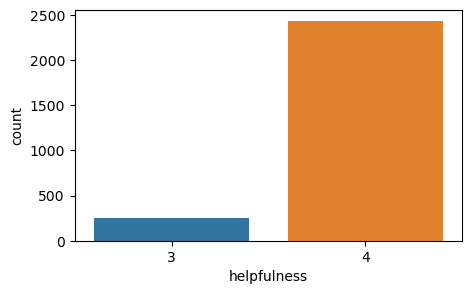

In [7]:
#visualization of data
plt.figure(figsize=(5,3))
sns.countplot(ecom, x="helpfulness")

<Axes: xlabel='gender', ylabel='count'>

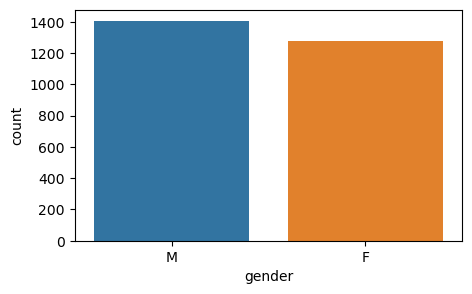

In [8]:
plt.figure(figsize=(5,3))
sns.countplot(ecom, x="gender")


<Axes: xlabel='rating', ylabel='count'>

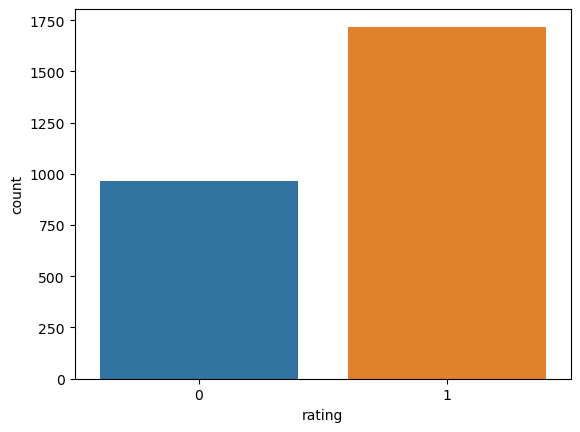

In [9]:
sns.countplot(ecom, x="rating")

# Data Processing

In [10]:
#checking data types of the columns
ecom.dtypes

timestamp        int64
userId           int64
review          object
item            object
helpfulness      int64
gender          object
category        object
item_id          int64
item_price     float64
user_city        int64
rating           int64
dtype: object

In [11]:
#checking for null values
ecom.isna().sum()

timestamp      0
userId         0
review         0
item           0
helpfulness    0
gender         0
category       0
item_id        0
item_price     0
user_city      0
rating         0
dtype: int64

In [12]:
#Using info method to see data in more details
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    2685 non-null   int64  
 1   userId       2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   helpfulness  2685 non-null   int64  
 5   gender       2685 non-null   object 
 6   category     2685 non-null   object 
 7   item_id      2685 non-null   int64  
 8   item_price   2685 non-null   float64
 9   user_city    2685 non-null   int64  
 10  rating       2685 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 230.9+ KB


### Converting object feature to numerical value

In [13]:
#converting categorical features into numerical values
ord_enc = OrdinalEncoder()
ecom["Item"] = ord_enc.fit_transform(ecom[["item"]])
ecom["Gender"] = ord_enc.fit_transform(ecom[["gender"]])
ecom["Category"] = ord_enc.fit_transform(ecom[["category"]])
ecom["Review"] = ord_enc.fit_transform(ecom[["review"]])

In [14]:
ecom.head()

,timestamp,userId,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating,Item,Gender,Category,Review
0,71900,4081,Not always McCrap,McDonald's,3,M,Restaurants & Gourmet,41,30.74,4,1,37.0,1.0,8.0,1618.0
1,72000,4081,I dropped the chalupa even before he told me to,Taco Bell,4,M,Restaurants & Gourmet,74,108.30,4,0,67.0,1.0,8.0,1125.0
2,72000,4081,The Wonderful World of Wendy,Wendy's,4,M,Restaurants & Gourmet,84,69.00,4,1,77.0,1.0,8.0,2185.0
3,100399,4081,They actually did it,"South Park: Bigger, Longer & Uncut",3,M,Movies,68,143.11,4,1,61.0,1.0,5.0,2243.0
4,100399,4081,Hey! Gimme some pie!,American Pie,3,M,Movies,6,117.89,4,0,5.0,1.0,5.0,1033.0


In [15]:
#removing object columns
objectFree_ecom = ecom.drop(['review', 'item', 'category', 'gender'], axis=1)

In [16]:
#showing dataframe without any object column
objectFree_ecom.head(10)

,timestamp,userId,helpfulness,item_id,item_price,user_city,rating,Item,Gender,Category,Review
0,71900,4081,3,41,30.74,4,1,37.0,1.0,8.0,1618.0
1,72000,4081,4,74,108.30,4,0,67.0,1.0,8.0,1125.0
2,72000,4081,4,84,69.00,4,1,77.0,1.0,8.0,2185.0
3,100399,4081,3,68,143.11,4,1,61.0,1.0,5.0,2243.0
4,100399,4081,3,6,117.89,4,0,5.0,1.0,5.0,1033.0
5,100399,4081,3,40,24.51,4,0,36.0,1.0,5.0,925.0
6,100399,4081,3,12,44.00,4,1,11.0,1.0,5.0,1854.0
7,101899,4081,4,25,80.00,4,1,23.0,1.0,4.0,795.0
8,112099,4081,3,22,87.59,4,1,21.0,1.0,5.0,262.0
9,122899,4081,3,49,32.00,4,1,44.0,1.0,8.0,2643.0


### Finding Correlation

In [17]:
#Determing cor-relation between columns
ecom = objectFree_ecom
corr_matrix = ecom.corr()
print(corr_matrix)

             timestamp    userId  helpfulness   item_id  item_price  \
timestamp     1.000000 -0.069176     0.014179 -0.004452    0.010979   
userId       -0.069176  1.000000    -0.166136 -0.005549    0.024576   
helpfulness   0.014179 -0.166136     1.000000 -0.019882    0.004112   
item_id      -0.004452 -0.005549    -0.019882  1.000000   -0.054450   
item_price    0.010979  0.024576     0.004112 -0.054450    1.000000   
user_city    -0.014934 -0.030031     0.012086 -0.005576   -0.023427   
rating       -0.009739  0.066444    -0.010622  0.057107    0.026062   
Item         -0.003543 -0.005513    -0.020433  0.999765   -0.049885   
Gender       -0.003367 -0.058324     0.075947  0.002370   -0.040596   
Category      0.015009 -0.041362    -0.013408 -0.045268   -0.115571   
Review        0.007029  0.007139    -0.028259  0.163544   -0.041421   

             user_city    rating      Item    Gender  Category    Review  
timestamp    -0.014934 -0.009739 -0.003543 -0.003367  0.015009  0.007029

<Axes: >

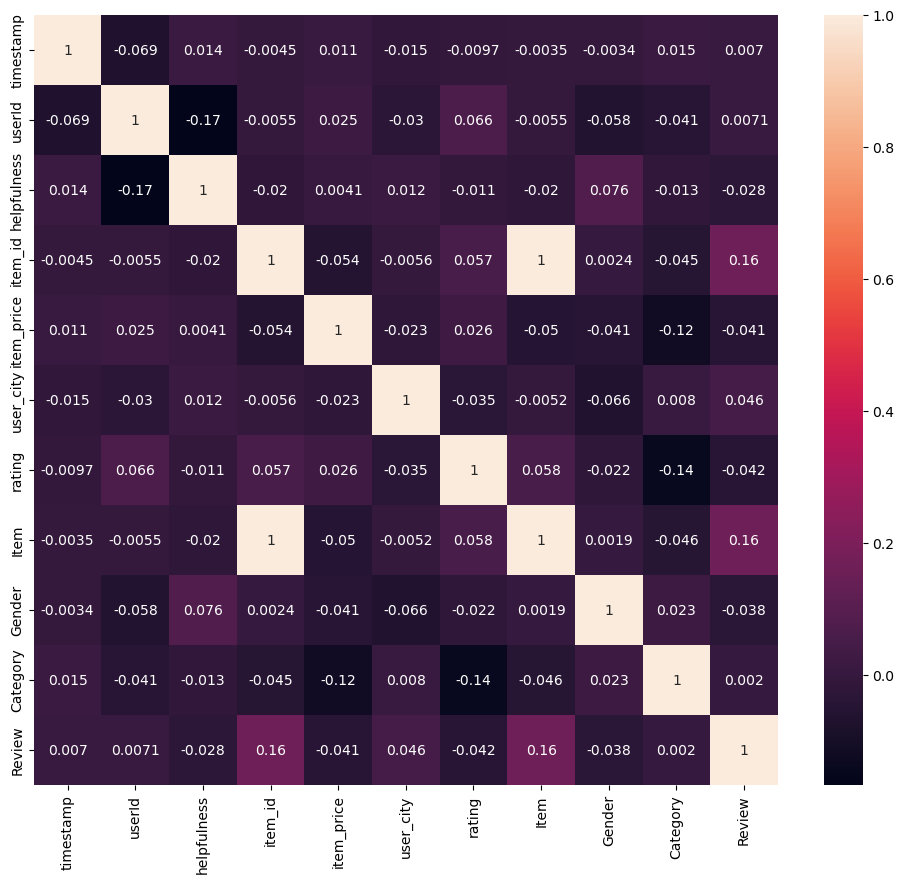

In [18]:
# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=False)
#
# Draw the heatmap
#
sns.heatmap(corr_matrix, annot=True)

**Here from the heatmap we can see that most highly correlated feature in terms of rating is category with -0.14 where (-) sign indicates it's a negative correlation.On the other hand, least correlated feature in terms of rating is timestamp with -0.0097. Here, highly positive correlations are userId, Item, item_id, item_price while Category, Review, user_city and Gender correlations are highly negative.**

# Logistic Regression

In [19]:
#split training and testing data
train, test = train_test_split(ecom, test_size=0.2, random_state=142)

Here we are spliting the dataset into 2 parts train and test. We will use train part to train the model and test part to test the model to find out whether it's working fine or not.

In [20]:
#printing training and test data shape
print(train.shape)
print(test.shape)

(2148, 11)
(537, 11)


In [21]:
# Defining input variable
X_train = train.drop(['rating'], axis = 1)
y_train = train['rating']

X_test = test.drop(['rating'], axis = 1)
y_test = test['rating']

In [22]:
#shape of X_train, y_train, X_test, y_test
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2148, 10), (2148,), (537, 10), (537,))

In [23]:
# Build your Logistic Regression model
model = linear_model.LogisticRegression()

In [24]:
#train model
model.fit(X_train, y_train)

LogisticRegression()

## Evaluation

In [25]:
# Do predictions on test set
predicted_test = model.predict(X_test)

In [26]:
# Evaluate the performance of your trained model
accuracy = accuracy_score(y_test, predicted_test)

In [27]:
print('Accuracy of test data is : ',accuracy)

Accuracy of test data is :  0.6685288640595903


In [28]:
print('confusion matrix: \n', confusion_matrix(y_test, predicted_test))

confusion matrix: 
 [[  0 178]
 [  0 359]]


## Feature selection

In [29]:
#Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [89]:
rfe_model = linear_model.LogisticRegression()
rfe = RFE(estimator= rfe_model, n_features_to_select= 3, step = 1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=3)

In [90]:
rfe.support_

array([False, False, False,  True, False, False,  True, False,  True,
       False])

In [91]:
rfe.ranking_

array([7, 2, 8, 1, 5, 3, 1, 4, 1, 6])

In [92]:
predicted_rfe = rfe.predict(X_test)

In [93]:
accuracy = accuracy_score(y_test, predicted_rfe)

In [94]:
print('The accuracy is: ', accuracy)

The accuracy is:  0.6666666666666666


# Logistic Regression based on RFE

In [95]:
# Defining input variable
X_train = train.drop(['timestamp', 'userId','helpfulness','item_price', 'user_city','Gender','Review', 'rating'], axis = 1)
y_train = train['rating']

X_test = test.drop(['timestamp', 'userId','helpfulness','item_price', 'user_city','Gender','Review', 'rating'], axis = 1)
y_test = test['rating']

In [96]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2148, 3), (2148,), (537, 3), (537,))

In [97]:
# Build your Logistic Regression model
model = linear_model.LogisticRegression()

In [98]:
#train model
model.fit(X_train, y_train)

LogisticRegression()

In [99]:
# Do predictions on test set
predicted_test = model.predict(X_test)

In [100]:
# Evaluate the performance of your trained model
accuracy = accuracy_score(y_test, predicted_test)

In [101]:
print('Accuracy of test data is : ',accuracy)

Accuracy of test data is :  0.6703910614525139


In [102]:
print('confusion matrix: \n', confusion_matrix(y_test, predicted_test))

confusion matrix: 
 [[ 13 165]
 [ 12 347]]


**We built a logistic regression model based on all the features and we found the accuracy of 0.6685288640595903. After that, we used RFE to select best features to build a best model and found 3 good features which gives us best accuracy of 0.6629422718808193. We varified the rfe accuracy by builting another logistic regression model where we select the 3 best features and removed other features and got the accuracy of 0.6703910614525139.**

# KNN

In [44]:
# Defining input variable
X_train = train.drop(['rating'], axis = 1)
y_train = train['rating']

X_test = test.drop(['rating'], axis = 1)
y_test = test['rating']

In [45]:
#shape of X_train, y_train, X_test, y_test
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2148, 10), (2148,), (537, 10), (537,))

In [46]:
#Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [47]:
# Define the model: Init K-NN
knn = KNeighborsClassifier(n_neighbors=3, p=2,metric='euclidean')

In [48]:
# Fit Model
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [49]:
# Predict the test set results
y_pred = knn.predict(X_test)

In [50]:
# Evaluate Model
print('f1_score : ',f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :\n',cm)


f1_score :  0.7128987517337032
Confusion Matrix :
 [[ 73 105]
 [102 257]]


In [51]:
print('Accuracy_score : ',accuracy_score(y_test, y_pred))

Accuracy_score :  0.6145251396648045


## Using GridSearchCV to find best K value

In [52]:
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)
GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [53]:
gridsearch.best_params_

{'n_neighbors': 26}

Best K value is 26

## KNN based on new k value by GridsearchCV 

In [54]:
# Define the model: Init K-NN
knn = KNeighborsClassifier(n_neighbors=26, p=2,metric='euclidean')

In [55]:
# Fit Model
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=26)

In [56]:
# Predict the test set results
y_pred = knn.predict(X_test)

In [57]:
# Evaluate Model
print('f1_score : ',f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :\n',cm)

f1_score :  0.7696139476961396
Confusion Matrix :
 [[ 43 135]
 [ 50 309]]


In [58]:
print('Accuracy_score : ',accuracy_score(y_test, y_pred))

Accuracy_score :  0.6554934823091247


**By using KNN model we find f1_score = 0.7128987517337032 and accuracy_score = 0.6145251396648045 where k value was 3. To determine the best k value we used GridSerachCV and it is 26. We build KNN model again and this time it's performance is better than previous one. New f1_score is 0.7696139476961396 and accuracy_score is 0.6554934823091247.**

## Comparison of Logistic Regression model and KNN model

**Based on the results of both model we have seen KNN model performs better than logistic regression model for this dataset.**